# Satellite Data Processing Pipeline

The aim of this notebook is to download and preprocess satellite image data from Google Earth Engine in order to conduct an analysis of impervious surfaces in Shanghai over 30 years.


### Workflow Overview

1. **Collect satellite data**  
   We collect multiple satellite data to improve coverage, reduce temporal gaps, and increase data reliability.

2. **Remove clouds**  
   Clouds and shadows obscure land cover, leading to misclassification.

3. **Harmonize sensors**  
   Each satellite has different spectral characteristics and resolutions; harmonization ensures consistency.

4. **Calculate indices**  
   Indices like NDVI, NDBI, etc., help distinguish vegetation, water, and built-up areas. These can be used to compute land cover or impervious surfaces.

<!-- 5. **Map impervious surfaces**  
   Identify non-permeable areas (roads, buildings). -->

6. **Create composites**  
   Composites of multiple images reduce noise from clouds and seasonal variations, (theoretically) providing a cleaner dataset.



### Primary References
- Wang, H., Zhang, Y., Tsou, J. Y., & Li, Y. (2017). Surface Urban Heat Island 
  Analysis of Shanghai (China) Based on the Change of Land Use and Land Cover. 
  Sustainability, 9(9), 1538. https://doi.org/10.3390/su9091538

- Yang, Y., Shen, G., Zhang, C., Sun, H., Zhang, Z., & Yin, S. (2022). 
  Quantitative analysis and prediction of urban heat island intensity on 
  urban-rural gradient: A case study of Shanghai. Science of the Total 
  Environment, 829, 154264. https://doi.org/10.1016/j.scitotenv.2022.154264

- Zha, Y., Gao, J., & Ni, S. (2003). Use of normalized difference built-up 
  index in automatically mapping urban areas from TM imagery. International 
  Journal of Remote Sensing, 24(3), 583-594.


## Install & import necessary libraries

In [260]:
%pip install earthengine-api geemap geedim

Note: you may need to restart the kernel to use updated packages.


In [261]:
import ee
import geemap
import matplotlib.pyplot as plt
import os
import pandas as pd
import rasterio
# import time

## Authenticate and initialize project (only run authenticate once)

In [262]:
ee.Authenticate() # Can be commented out after first authentication

True

In [263]:
ee.Initialize(project="ee-helyne")

## Setup download directory

In [342]:
# Create local data directory
data_dir = "/home/jovyan/shared-public/poseidon_heatwaves/data/"  
data_dir = "/Users/helyne/code/climatematch/poseidon_heatwaves/data/"  
landsat_dir = os.path.join(data_dir, "landsat_shanghai")
os.makedirs(landsat_dir, exist_ok=True)

print(f"Data will be saved to: {landsat_dir}")

Data will be saved to: /Users/helyne/code/climatematch/poseidon_heatwaves/data/landsat_shanghai


# Download data for Shanghai

In [343]:
# Define our study area - Shanghai, China
shanghai_bounds = [120.8, 30.6, 122.2, 31.9] # [West, South, East, North]
shanghai = ee.Geometry.Rectangle(shanghai_bounds)

In [344]:
# Preprocessing steps

def mask_clouds(image):
    """
    Remove clouds and cloud shadows from Landsat imagery.
    
    Cloud masking is essential because:
    - Clouds block our view of the ground surface
    - They have very different temperatures and reflectance
    - Without masking, clouds would be classified as bright urban areas
    - This would mess up our impervious surface mapping
    
    Args:
        image: Landsat image with QA_PIXEL band
        
    Returns:
        Image with cloud and shadow pixels masked
    """
    print("🌤️ Removing clouds and shadows...")
    
    # Get the quality assessment band (QA_PIXEL)
    # This band contains bit-encoded quality information for each pixel
    qa = image.select('QA_PIXEL')
        
    # Extract cloud and cloud shadow bits using bitwise operations (1 = bit set, 0 = bit clear)
    # `bitwiseAnd(1 << N)` isolates the Nth bit
    cloud_bit = 1 << 3        # Binary: 1000 (bit 3)
    shadow_bit = 1 << 4       # Binary: 10000 (bit 4)
    snow_ice_bit = 1 << 5     # Binary: 100000 (bit 5)
    
    # Create masks: True = clear pixel, False = cloudy/shadow pixel
    # `.eq(0)` checks if the bit is NOT SET (condition absent)
    cloud_mask = qa.bitwiseAnd(cloud_bit).eq(0)    # 0 = no cloud
    shadow_mask = qa.bitwiseAnd(shadow_bit).eq(0)   # 0 = no cloud shadow
    snow_ice_mask = qa.bitwiseAnd(snow_ice_bit).eq(0)   # 0 = no snow/ice
    
    # Combine masks: keep only pixels that are both cloud-free AND shadow-free
    clear_mask = cloud_mask.And(shadow_mask).And(snow_ice_mask)
    
    # Apply the mask to hide cloudy/shadow pixels
    return image.updateMask(clear_mask)

def harmonize(image):
    """
    Harmonize band names and scaling across different Landsat satellites.
    
    Different Landsat satellites (5/7 vs 8/9) have different band numbering
    schemes. This function standardizes them to common names and applies
    proper scaling factors.
    
    Args:
        image: Raw Landsat image
        
    Returns:
        Harmonized image with consistent band names and scaling
    """
    print("🔧 Harmonizing different satellite sensors...")
    
    # Identify which satellite took this image
    spacecraft = ee.String(image.get('SPACECRAFT_ID'))
    
    # Define band mappings for each satellite
    # L8 has different band numbers than L5/7
    landsat89_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    landsat57_bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
    common_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    # Choose band mappings based on satellite type
    spacecraft = ee.String(image.get('SPACECRAFT_ID'))
    is_oli = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(spacecraft)
    harmonized = ee.Algorithms.If(
        is_oli,
        image.select(landsat89_bands, common_names),  # select landsat8/9 band mapping if true
        image.select(landsat57_bands, common_names)
    )
    
    # Apply appropriate scaling
    scaled = ee.Image(harmonized).multiply(0.0000275).add(-0.2)
    
    return scaled.copyProperties(image, ['system:time_start'])  # copy time info

def compute_spectral_indices(image):
    """
    Add spectral indices useful for land cover classification.
        
    WHAT ARE SPECTRAL INDICES?
    - Mathematical combinations of different wavelengths (bands)
    - Each index highlights different surface materials (e.g. vegetation or water)
        
    1. NDVI (Normalized Difference Vegetation Index)
        - Formula: (NIR - Red) / (NIR + Red)
        - Plants reflect lots of near-infrared but absorb red light
        - Result: High NDVI = lots of vegetation, Low NDVI = little vegetation
    
    2. MNDWI (Modified Normalized Difference Water Index)
        - Formula: (Green - SWIR) / (Green + SWIR)
        - Water absorbs shortwave infrared but reflects green light
        - Result: High MNDWI = water bodies, Low MNDWI = land surfaces, vegetation, or soil
    
    3. NDBI (Normalized Difference Built-up Index) - for comparison
        - Formula: (SWIR - NIR) / (SWIR + NIR)
        - Buildings/concrete reflect more shortwave infrared than vegetation
        - Result: High NDBI = urban areas, Low NDBI = natural areas
        - Note: This is a modern validation method not in our reference studies. 
                We can compare this with the NDVI-based method for validation.
                
    Args:
        image: Harmonized Landsat image with standard band names
        
    Returns:
        Image with additional spectral index bands
    """
    print(f"🧮 Calculating spectral indices...")
    
    return image.addBands([
        image.normalizedDifference(['nir', 'red']).rename('NDVI'),
        image.normalizedDifference(['green', 'swir1']).rename('MNDWI'),
        image.normalizedDifference(['swir1', 'nir']).rename('NDBI')
    ])


## Impervious Surface Measurement Methodology


We can derive surface imperviousness using two complementary approaches:

### Primary Method: Dimidiate Pixel Model (Wang et al., 2017)

The Dimidiate Pixel Model assumes each pixel contains a mixture of vegetation and non-vegetation. By measuring vegetation density (NDVI), we infer the remaining fraction as impervious surface.

Wang et al. (2017) use the Normalized Difference Vegetation Index (NDVI) to estimate impervious surfaces based on the inverse relationship between vegetation and urban development. Both Wang et al. and Yang et al. excluded water bodies from their impervious surface calculations because water isn't "impervious" in the urban planning sense. MNDWI identifies water pixels (rivers, lakes) so we can mask them out before calculating impervious surface percentages.

So the general approach is:
1. Calculate vegetation coverage using min/max NDVI values
2. Impervious surface = 1 - vegetation coverage  
3. Apply water mask to exclude water bodies

**Implementation:**

**Step 1: Calculate NDVI**
```
ndvi = (NIR - Red) / (NIR + Red)
```

**Step 2: Compute vegetation coverage**
```
vegetation_coverage = (ndvi - ndvi_min) / (ndvi_max - ndvi_min)
```
Will use the absolute values

**Step 3: Cmopute impervious surface**
```
impervious_surface = 1 - vegetation_coverage
```

**Step 4: Compute water index (MNDWI)**
```
mndwi = (Green - SWIR) / (Green + SWIR)
```

**Step 5: Create water mask**
```
water_mask = mndwi.lt(0.3)  # mask to keep land, exclude water
```
Water has very low NDVI (similar to impervious surfaces), so we need to mask it out of our impervious surface map. The [Wikipedia article](https://en.wikipedia.org/wiki/Normalized_difference_water_index#Interpretation) for MNDWI suggests the following interpretation of values:
- High MNDWI values (>0.3) = Water
- Low MNDWI values (<0.3) = Non-water (vegetation, soil, concrete, etc.)


**Step 6: Apply water mask**
```
impervious_final = impervious_surface.updateMask(water_mask)
```


### Alternative Method: Yang et al. (2022)

**Yang et al. used supervised classification** to find and tag impervious surface as a land cover class.

**Problems with classification approach:**
- Classification requires manual training sample collection
- More subjective and computationally complex  
- Our formula approach is more reproducible and easier to implement for our 2-week project

### Validation Method: NDBI (Zha et al., 2003)

In contrast, Zha et al. (2003) developed the Normalized Difference Built-up Index (NDBI) to quantify impervious surfaces.

**Formula for Built-up Index**
```
NDBI = (SWIR - NIR) / (SWIR + NIR)
```

We can include NDBI as an **independent validation** - it highlights urban areas using different spectral properties than NDVI, helping validate/confirm our results or provide an interesting comparison analysis.

In [ ]:
# Otsu thresholding method (not used -> can't do it on the server)
# def otsu_threshold(img_band: ee.Image,
#                    region: ee.Geometry,
#                    *,
#                    scale: int = 30,
#                    bins: int = 256) -> ee.Number:
#     """
#     Finds the Otsu threshold for a single-band ee.Image.

#     Parameters
#     ----------
#     img_band : ee.Image
#         Single band to threshold (e.g. MNDWI).
#     region : ee.Geometry
#         Area over which to compute the histogram.
#     scale : int, optional
#         Pixel size in metres. Default 30 m (Landsat).
#     bins : int, optional
#         Number of histogram bins. Default 256.

#     Returns
#     -------
#     ee.Number
#         Grey-level (index value) that maximises between-class variance.
#     """
#     # 1. Histogram on the server
#     hist = (
#         img_band
#         .reduceRegion(
#             ee.Reducer.histogram(maxBuckets=bins),
#             geometry=region,
#             scale=scale,
#             maxPixels=1e9)
#         .get(img_band.bandNames().get(0))
#     )
#     hist = ee.Dictionary(hist)

#     counts = ee.Array(hist.get('histogram'))
#     means = ee.Array(hist.get('bucketMeans'))

#     # 2. Probabilities
#     total = counts.reduce('sum', [0]).get([0])
#     p = counts.divide(total)

#     # 3. Cumulative sums
#     omega = p.cumsum(0)    # class weights
#     mu = means.multiply(p).cumsum(0)    # class means
#     mu_tot = mu.get([-1])   # global mean

#     # 4. Between-class variance
#     sigma_b2 = omega.multiply(ee.Array(1).subtract(omega)) \
#                       .multiply(mu_tot.multiply(ee.Array.ones(mu.length())).subtract(mu).divide(omega) -
#                                 (mu_tot.subtract(mu)).divide(ee.Array(1).subtract(omega)))**2

#     # 5. Threshold = mean bin that maximises σ_B²
#     idx = sigma_b2.argmax()
#     return means.get(idx)   # ee.Number

In [412]:
# Impervious surfaces calculation

def compute_impervious_surfaces(image):
    """
    Calculate impervious surfaces
    
    WHAT ARE IMPERVIOUS SURFACES?
    - Surfaces that don't absorb water: concrete, asphalt, rooftops, parking lots
    - Key indicator of urbanization and development intensity
    - Relevant for urban heat island studies (e.g.concrete heats up more than grass)
    
    Args:
        image: Harmonized Landsat image with standard band names and computed spectral indices
        
    Returns:
        Image with additional computed measure: impervious surface (IS)
    """
    print("🏙️  Mapping impervious surfaces...")

    # Strategy 1: Inverse vegetation (Dimidiate Pixel Model) (after Wang et al. 2017)
    # Where there's lots of plants, there's little concrete
    
    # 1. Get our calculated indices
    ndvi = image.select('NDVI')
    ndbi = image.select('NDBI')
    mndwi = image.select('MNDWI')

    # 2. Calculate min/max NDVI (for vegetation coverage calculation)
    ndvi_stats = ndvi.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=shanghai,
        scale=30,
        maxPixels=1e9
    )
    ndvi_min = ee.Number(ndvi_stats.get('NDVI_min'))
    ndvi_max = ee.Number(ndvi_stats.get('NDVI_max'))

    # 3. Compute vegetation coverage (continuous 0-1) using dimidiate pixel model
    # Vc = (NDVI - NDVImin) / (NDVImax - NDVImin)
    vc = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min))
    
    # 4. Calculate impervious surface (Wang et al. formula)
    # Impervious surface = 1 - vegetation coverage
    impervious_surface = ee.Image(1).subtract(vc).clamp(0, 1)
    
    # 5. Threshold MNDWI and apply water mask
    # Threshold water index to be sure we're only masking water (water > 0.3)
    water_mask = mndwi.lt(0.3)  # mask to exclude water & keep land

        # # 5. Calculate Otsu threshold for water masking
        # # Alternative water masking: use Otsu's thresholding to automatically find the best threshold for water masking
        # # Reference: https://google-earth-engine.com/Aquatic-and-Hydrological-Applications/Surface-Water-Mapping/
        # otsu_thresh = otsu_threshold(mndwi, shanghai)
        
        # # 6. Apply Otsu threshold for water masking
        # # Water pixels have high MNDWI values, so we want to exclude them
        # water_mask = mndwi.lt(otsu_thresh)  # Keep pixels below threshold (land)

    # 7. Apply water mask
    impervious_final = impervious_surface.updateMask(water_mask).rename('IS').toFloat()
    ndbi_masked = ndbi.updateMask(water_mask).rename('NDBI_masked').toFloat()

    return (image
            .addBands(impervious_final)
            .addBands(ndbi_masked))



In [413]:
# Putting it all together to create an annual composite image for a given year
def annual_image(year, return_only_indices=True):
    """
    Create annual composite image from all available Landsat data.
    
    This function processes a full year of Landsat imagery by:
    1. Merging data from multiple Landsat satellites (5, 7, 8, 9)
    2. Filtering by location, date, and cloud cover
    3. Applying cloud masking, harmonization, and index calculation
    4. Creating a median composite to reduce noise and gaps
    5. Selecting only the indices we need
    
    Args:
        year: Year for which to create the composite (int)
        
    Returns:
        Annual median composite with NDVI, MNDWI, and NDBI bands
    """
    print(f"\n📡 Collecting Landsat data for {year}")
    
    # Collect all available Landsat data for the year
    landsat_collection = (
                    ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
                   .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
                   .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
                   .merge(ee.ImageCollection('LANDSAT/LC09/C02/T1_L2'))
                   .filterBounds(shanghai)
                   .filterDate(f'{year}-01-01', f'{year}-12-31')
                   .filter(ee.Filter.lt('CLOUD_COVER', 20))  # Only images with <20% clouds
                   )
    
    # Process all images and create median composite
    median_composite = (landsat_collection
                        .map(mask_clouds)
                        .map(harmonize)
                        .map(compute_spectral_indices)
                        .median())
    
    # Compute impervious surfaces for the median composite
    median_composite = compute_impervious_surfaces(median_composite)
    
    if return_only_indices:
        annual_image = median_composite.select(['IS', 'NDBI', 'NDBI_masked'])  # return only the indices we need
    else:
        annual_image = median_composite   # return all bands & indices
    
    # Set year as a property of the image
    annual_image = annual_image.set('year', year)
    
    # Reproject and scale
    # For Shanghai (≈ 31°N, 121°E) the usual choice is UTM zone 51 N, EPSG 32651
    # 30 m Landsat native resolution
    return annual_image.reproject(crs='EPSG:32651', scale=30)


In [414]:
# Create a dataset annual composites
start_year = 1990
end_year = 2025

shanghai_impervious_30yrs = []

for yr in range(start_year, end_year):
    shanghai_impervious_30yrs.append(annual_image(yr, return_only_indices=False))

shanghai_impervious_30yrs


📡 Collecting Landsat data for 1990
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...

📡 Collecting Landsat data for 1991
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...

📡 Collecting Landsat data for 1992
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors.

# Visually inspect and sanity check

In [349]:
# Create map
Map = geemap.Map(center=[31.2304, 121.4737], zoom=10)

# Get annual image
image = shanghai_impervious_30yrs[-1]
image_year = image.get('year').getInfo()

# Add all layers with simple vis params
# Map.addLayer(image.select('NDVI'), {'min': -1, 'max': 1, 'palette': ['red', 'yellow', 'green']}, f'NDVI {image_year}')
# Map.addLayer(image.select('MNDWI'), {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'blue']}, f'MNDWI {image_year}')
Map.addLayer(image.select('IS'), {'min': 0, 'max': 1, 'palette': ['black', 'white']}, f'IS {image_year}')
# Map.addLayer(image.select('NDBI'), {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}, f'NDBI {image_year}')

Map

Map(center=[31.2304, 121.4737], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

# Calculate stats

Here we calculate:

**Mean**
- Simple average value of the index across all pixels.
- Overall urbanization level (baseline measure).
- Higher mean → more built-up across the entire region.

**90th percentile**
- Value exceeded by only 10 % of pixels.
- Captures the urban core’s intensity.
- 90th percentile focuses on most urban areas where heat islands are strongest.
- Indicates how high imperviousness (or "built-up-ness") gets in the densest areas.
- Example: High p90 but low mean ⇒ compact, very dense core surrounded by less‑built land.

**High urban fraction**
- Share of pixels above a fixed urban threshold (IS > 0.70 or NDBI > 0.20).
- Spatial spread of very dense urban areas. 
- High value = large portion of the city is intensely urbanized.
- 0 → None of the region is strongly urbanised; 1 → Everything is urbanised.

**High‑urban area (km²)**
- Absolute footprint in km² of those high‑urban pixels.
- Might be useful

In [ ]:
# create stats extractor functions

def _combine_mean_p90():
    """
    Return a reducer that outputs mean and 90-th percentile.
    
    Helper function to optimise speed - one composite reducer that emits both 
    statistics in a single server call. Calling that composite reducer inside 
    reduceRegion() which is inside extract_key_metrics() gives the mean and the 90-th 
    percentile together, so Earth Engine scans the pixels only once instead of twice.
    """
    return (ee.Reducer.mean()
              .combine(ee.Reducer.percentile([90]), 
                       sharedInputs=True)
              .setOutputs(['mean', 'p90']))
            
def extract_key_metrics(
        image,
        region,
        band='IS'):
    """
    Extract only the most important metrics for heat wave correlation.
    
    1. mean_{band}
        Mean of the band; basic proxy for overall urbanization level
    2. p90_{band}
        90-th percentile; characterises the densest/most "built-up" 10 % of pixels; 
        sort of like built-up intensity of the urban “core”
    3. high_{band}_frac
        Fraction of pixels above a fixed urban threshold;
        IS > 0.70 or NDBI > 0.20 (NDBI between 0.2-0.7 is typical for built-up)
    4. high_{band}_area_km2
        Absolute area (km²) of those high-urban pixels; might be useful.
        
    Args:
        image: ee.Image
        region: Study area geometry as ee.Geometry
        band_name: Name of the index band to extract metrics from (e.g. 'IS')
    
    Returns:
        ee.Feature with key metrics (basically a dictionary, but optimised for server-side processing with Earth Engine)
    """
    
    thr = {'IS': 0.70, 'NDBI': 0.2, 'NDBI_masked': 0.2} # NDBI = 0.2-0.7 is typical for built-up

    idx = image.select(band)

    # 1. Mean & 90-th percentile in one server call
    stats = idx.reduceRegion(
        reducer=_combine_mean_p90(),
        geometry=region, 
        scale=30,
        maxPixels=1e13, 
        bestEffort=True
        )

    # 2. High urban fraction
    high = idx.gt(thr[band])
    px_area = ee.Image.pixelArea()

    high_area = px_area.updateMask(high).reduceRegion(
        ee.Reducer.sum(),
        region, 
        scale=30,
        maxPixels=1e13, 
        bestEffort=True
        ).values().get(0)

    total_area = px_area.updateMask(idx).reduceRegion(
        ee.Reducer.sum(), 
        region, 
        scale=30,
        maxPixels=1e13, 
        bestEffort=True
        ).values().get(0)

    high_frac = ee.Number(high_area).divide(total_area)

    # 3. pack everything into a Feature
    mean_key = f'{band}_mean'
    p90_key  = f'{band}_p90'
    
    return ee.Feature(None, {
        'year'                : image.getNumber('year'),
        f'mean_{band}'        : stats.get(mean_key),
        f'p90_{band}'         : stats.get(p90_key),
        f'high_{band}_frac'   : high_frac,
        f'high_{band}_area_km2': ee.Number(high_area).divide(1e6)   # how many square-kilometres are “strongly urban”
    })    
    

In [ ]:
# # Old version of getting metrics 
            
# def extract_key_metrics(image, region, band_name):
#     """
#     Extract only the most important metrics for heat wave correlation.
    
#     Args:
#         image: ee.Image
#         region: Study area geometry as ee.Geometry
#         band_name: Name of the index band to extract metrics from (e.g. 'IS')
    
#     Returns:
#         Dictionary with key metrics
#     """


#     index_band = image.select(band_name)
#     year = image.get('year').getInfo()    
#     print(f'Extracting metrics for {band_name} in {year}')
        
#     # 1. Mean imperviousness (overall urbanization level)
#     mean_stats = index_band.rename(f'{band_name}_mean').reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=region,
#         scale=30,
#         maxPixels=1e9,
#         bestEffort=True
#     )
    
#     # 2. 90th percentile (focuses on most urban areas)
#     # intensity of the most built-up 10 % of pixels (good proxy for dense core)
#     p90_stats = index_band.rename(f'{band_name}_p90').reduceRegion(
#         reducer=ee.Reducer.percentile([90]),
#         geometry=region,
#         scale=30,
#         maxPixels=1e9,
#         bestEffort=True
#     )
    
#     # 3. High urban fraction (share of pixels above a specific urban threshold)
#     thresholds = {'IS': 0.7, 'NDBI': 0.2, 'NDBI_masked': 0.2} # NDBI = 0.2-0.7 is typical for built-up
#     thr = thresholds[band_name] # Values above 0 represent more built built-up areas

#     # Boolean mask of "high" pixels
#     high_mask = index_band.gt(thr)

#     # Count high pixels (sum of 1/0 mask)
#     high_px_stats = high_mask.reduceRegion(
#         reducer=ee.Reducer.sum(),  # sum of 1s
#         geometry=region,
#         scale=30,
#         maxPixels=1e9,
#         bestEffort=True
#     )

#     # Count total VALID pixels in the band (masked pixels excluded automatically)
#     total_px_stats = index_band.reduceRegion(
#         reducer=ee.Reducer.count(),
#         geometry=region,
#         scale=30,
#         maxPixels=1e9,
#         bestEffort=True
#     )
        
#     # Get values
#     mean_val = mean_stats.get(f'{band_name}_mean').getInfo() if mean_stats else None
#     p90_val = p90_stats.get(f'{band_name}_p90').getInfo() if p90_stats else None

#     high_px = high_px_stats.get(band_name).getInfo() if high_px_stats else 0
#     total_px = total_px_stats.get(band_name).getInfo() if total_px_stats else 0
#     high_fraction = (high_px / total_px) if total_px else 0

#     # mean_val = mean_stats.getInfo().get(f'{band_name}_mean', 0)
#     # p90_val = p90_stats.getInfo().get(f'{band_name}_p90', 0)
    
#     # total_px = total_pixels.getInfo().get(f'{band_name}_total', 1)
#     # high_px = high_pixels.getInfo().get(f'{band_name}_high_fraction', 0)
#     # high_fraction = high_px / total_px if total_px > 0 else 0
    
#     results = {
#         'year': year,
#         f'mean_{band_name}': mean_val,    # Overall urbanization
#         f'p90_{band_name}': p90_val,  # probably best for heat correlation
#         f'high_{band_name}_fraction': high_fraction  #  highly urban areas
#     }
    
#     return results

In [ ]:
# Get IS metrics
rows = []
for y in range(1990, 2025):                      # 35 tiny requests
    img   = annual_image(y)                      # the annual composite
    feat  = extract_key_metrics(img, shanghai)   # 3 reducers only
    rows.append(feat.getInfo()['properties'])    # pull just one year

# Convert to pandas DataFrame
df_is = pd.DataFrame(rows)

# Export immediately (in case notebook crashes)
df_is.to_csv('/Users/helyne/code/climatematch/poseidon_heatwaves/data/shanghai_df_is_stats.csv', index=False)

# Check the data
df_is


,high_IS_area_km2,high_IS_frac,mean_IS,p90_IS,year
0,0.012250,3.951581e-06,0.274870,0.416033,1990
1,0.004600,1.540372e-06,0.265864,0.392444,1991
2,1.078307,2.704117e-04,0.348369,0.494127,1992
3,0.033892,9.527869e-06,0.314812,0.419873,1993
4,0.210625,5.280722e-05,0.352094,0.486320,1994
5,0.000763,2.379339e-07,0.281693,0.427785,1995
6,0.011548,2.822028e-06,0.359163,0.474597,1996
7,0.180006,5.529088e-05,0.284054,0.447261,1997
8,0.040721,1.102383e-05,0.324989,0.466803,1998
9,0.009951,3.061691e-06,0.287122,0.447264,1999


In [ ]:
# Get NDBI masked metrics
rows = []
for y in range(1990, 2025):
    img   = annual_image(y) # the annual composite
    feat  = extract_key_metrics(img, shanghai, band='NDBI_masked')  # 3 reducers only
    rows.append(feat.getInfo()['properties'])   # pull just one year

# Convert to pandas DataFrame
df_ndbi_masked = pd.DataFrame(rows)

# Export immediately (in case notebook crashes)
df_ndbi_masked.to_csv('/Users/helyne/code/climatematch/poseidon_heatwaves/data/shanghai_df_ndbi_masked_stats.csv', index=False)

# Check the data
df_ndbi_masked

,high_NDBI_masked_area_km2,high_NDBI_masked_frac,mean_NDBI_masked,p90_NDBI_masked,year
0,0.351424,0.118232,-0.270263,-0.128979,1990
1,0.300184,0.070197,-0.233739,-0.097715,1991
2,0.392331,0.160578,-0.222673,-0.089883,1992
3,0.302557,0.026399,-0.141172,-0.035230,1993
4,0.416704,0.026591,-0.195003,-0.043091,1994
5,0.269117,0.039121,-0.250304,-0.089868,1995
6,0.226236,0.013825,-0.139851,-0.027371,1996
7,0.405518,0.037946,-0.228457,-0.074258,1997
8,0.572885,0.051000,-0.185841,-0.058649,1998
9,1.008254,0.050632,-0.191695,-0.027406,1999


In [438]:
# Get NDBI metrics
rows = []
for y in range(1990, 2025):
    img   = annual_image(y) # the annual composite
    feat  = extract_key_metrics(img, shanghai, band='NDBI')  # 3 reducers only
    rows.append(feat.getInfo()['properties'])   # pull just one year

# Convert to pandas DataFrame
df_ndbi = pd.DataFrame(rows)

# Export immediately (in case notebook crashes)
df_ndbi.to_csv('/Users/helyne/code/climatematch/poseidon_heatwaves/data/shanghai_df_ndbi_stats.csv', index=False)

# Check the data
df_ndbi


📡 Collecting Landsat data for 1990
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...

📡 Collecting Landsat data for 1991
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...

📡 Collecting Landsat data for 1992
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors.

,high_NDBI_area_km2,high_NDBI_frac,mean_NDBI,p90_NDBI,year
0,0.351424,0.118232,-0.394710,-0.175510,1990
1,0.300184,0.070197,-0.413216,-0.136775,1991
2,0.392331,0.160578,-0.369584,-0.121123,1992
3,0.310957,0.027124,-0.329313,-0.066393,1993
4,0.416704,0.026590,-0.360731,-0.082065,1994
5,0.269117,0.039121,-0.417150,-0.136793,1995
6,0.226236,0.013825,-0.359615,-0.050918,1996
7,0.405518,0.037946,-0.424977,-0.113279,1997
8,0.572885,0.050999,-0.358341,-0.089900,1998
9,1.008254,0.050632,-0.402429,-0.066534,1999


In [439]:
# Merge metrics by year
final_df = (
        df_is
        .merge(df_ndbi, on='year', how='inner')
        .merge(df_ndbi_masked, on='year', how='inner')
    )

# Export immediately (in case notebook crashes)
final_df.to_csv('/Users/helyne/code/climatematch/poseidon_heatwaves/data/shanghai_is_ndbi_stats.csv', index=False)

final_df

,high_IS_area_km2,high_IS_frac,mean_IS,p90_IS,year,high_NDBI_area_km2,high_NDBI_frac,mean_NDBI,p90_NDBI,high_NDBI_masked_area_km2,high_NDBI_masked_frac,mean_NDBI_masked,p90_NDBI_masked
0,0.012250,3.951581e-06,0.274870,0.416033,1990,0.351424,0.118232,-0.394710,-0.175510,0.351424,0.118232,-0.270263,-0.128979
1,0.004600,1.540372e-06,0.265864,0.392444,1991,0.300184,0.070197,-0.413216,-0.136775,0.300184,0.070197,-0.233739,-0.097715
2,1.078307,2.704117e-04,0.348369,0.494127,1992,0.392331,0.160578,-0.369584,-0.121123,0.392331,0.160578,-0.222673,-0.089883
3,0.033892,9.527869e-06,0.314812,0.419873,1993,0.310957,0.027124,-0.329313,-0.066393,0.302557,0.026399,-0.141172,-0.035230
4,0.210625,5.280722e-05,0.352094,0.486320,1994,0.416704,0.026590,-0.360731,-0.082065,0.416704,0.026591,-0.195003,-0.043091
5,0.000763,2.379339e-07,0.281693,0.427785,1995,0.269117,0.039121,-0.417150,-0.136793,0.269117,0.039121,-0.250304,-0.089868
6,0.011548,2.822028e-06,0.359163,0.474597,1996,0.226236,0.013825,-0.359615,-0.050918,0.226236,0.013825,-0.139851,-0.027371
7,0.180006,5.529088e-05,0.284054,0.447261,1997,0.405518,0.037946,-0.424977,-0.113279,0.405518,0.037946,-0.228457,-0.074258
8,0.040721,1.102383e-05,0.324989,0.466803,1998,0.572885,0.050999,-0.358341,-0.089900,0.572885,0.051000,-0.185841,-0.058649
9,0.009951,3.061691e-06,0.287122,0.447264,1999,1.008254,0.050632,-0.402429,-0.066534,1.008254,0.050632,-0.191695,-0.027406


# Plot annual urban metrics

There's something wrong with the impervious surface values, which could be related to a number of error sources.

For example, the landsat 7 data had some ([known issues around 2003](https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data)) and there are changes in quality from earlier sensors to more modern ones in landsat 8 and 9.

It could also be related to the way in which water is masked out of our impervious surface values. We use a hard-coded value of 0.3, which is generally appropriate, but might not be optimal for every year and then we'll get areas of water included in our impervious surface map. 

Alternatively, it could also be related to a sampling bias of some kind. Absolute minimum and maximum NDVI values could vary across years and across seasons. We might need to compute the NDVI minimum and maximum​ once for *all years* (or use 5th and 95th percentiles from the full 1990-2024 stack). For example:
- Pre-2010: few images → median often a leafy summer scene → high NDVI → high IS.
- Post-2010: many winter/shoulder-season scenes → lower NDVI → lower IS.

If we are doing a median composite of multiple satellites over a single year, there may be variations and weird extremes that we are capturing, espcially if some years have more satellite images from multiple satellites than other years and if some years have more winter scenes. This again, could also relate to the first potential error source of Landsat 7 having data quality issues.



On the plus side, the NDBI metric seems to be consistent with what we would expect of a growing city (general increase in developed land). Values above 0.2 are associated with urban development, but we are probably getting such low values because we are averaging over the whole image (which still includes quite a lot of vegetation as well as a lot of water). I've computed a masked version of the NDBI metric, which excludes water.

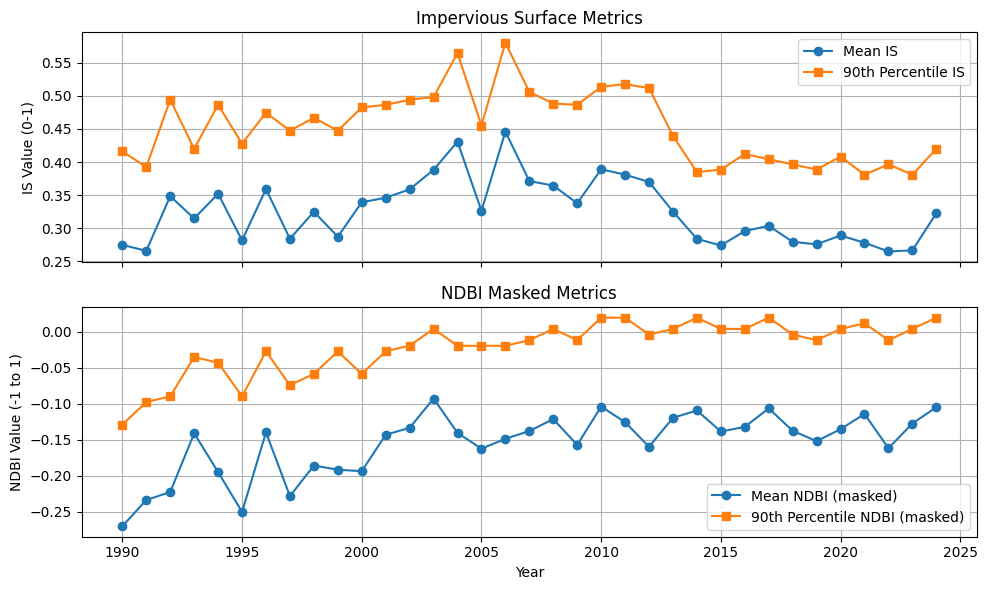

In [434]:
fig1, axs1 = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Impervious metrics
axs1[0].plot(years, final_df['mean_IS'], marker='o', label='Mean IS')
axs1[0].plot(years, final_df['p90_IS'], marker='s', label='90th Percentile IS')
axs1[0].set_ylabel('IS Value (0-1)')
axs1[0].set_title('Impervious Surface Metrics')
axs1[0].legend()
axs1[0].grid(True)

# NDBI Masked metrics
axs1[1].plot(years, final_df['mean_NDBI_masked'], marker='o', label='Mean NDBI (masked)')
axs1[1].plot(years, final_df['p90_NDBI_masked'], marker='s', label='90th Percentile NDBI (masked)')
axs1[1].set_ylabel('NDBI Value (-1 to 1)')
axs1[1].set_xlabel('Year')
axs1[1].set_title('NDBI Masked Metrics')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()

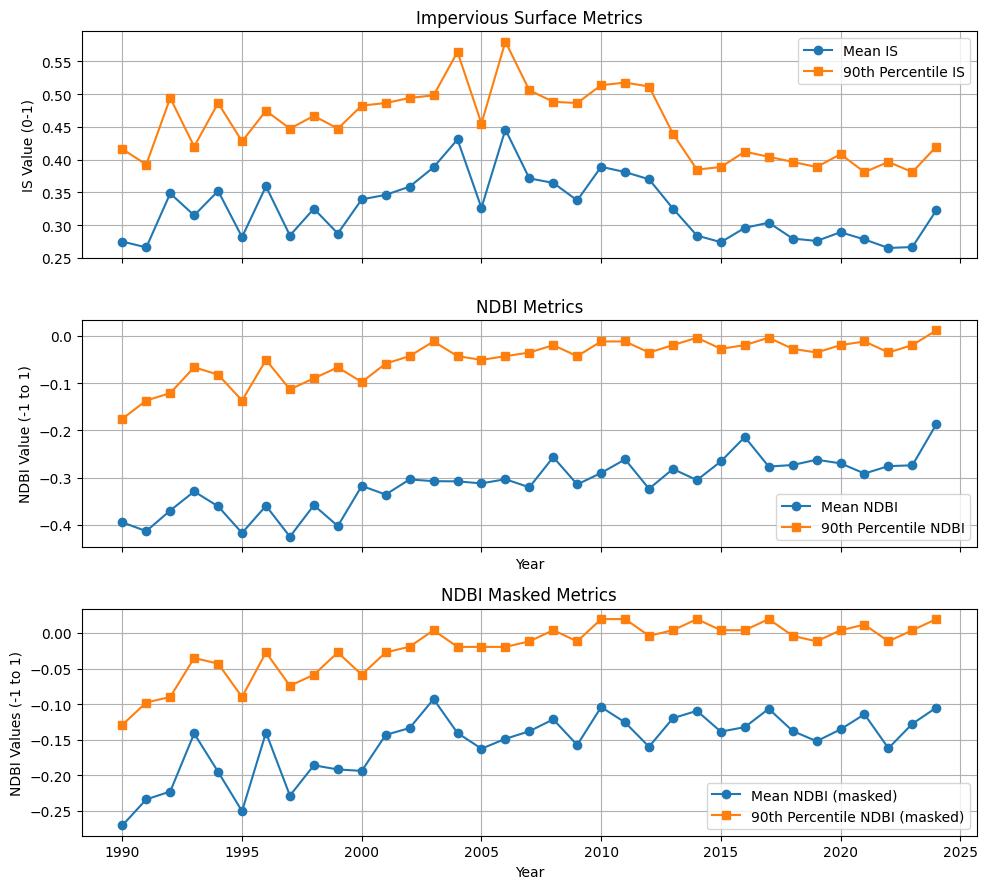

In [440]:
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Impervious metrics
axs1[0].plot(years, final_df['mean_IS'], marker='o', label='Mean IS')
axs1[0].plot(years, final_df['p90_IS'], marker='s', label='90th Percentile IS')
axs1[0].set_ylabel('IS Value (0-1)')
axs1[0].set_title('Impervious Surface Metrics')
axs1[0].legend()
axs1[0].grid(True)

# NDBI metrics
axs1[1].plot(years, final_df['mean_NDBI'], marker='o', label='Mean NDBI')
axs1[1].plot(years, final_df['p90_NDBI'], marker='s', label='90th Percentile NDBI')
axs1[1].set_ylabel('NDBI Value (-1 to 1)')
axs1[1].set_xlabel('Year')
axs1[1].set_title('NDBI Metrics')
axs1[1].legend()
axs1[1].grid(True)

# NDBI Masked metrics
axs1[2].plot(years, final_df['mean_NDBI_masked'], marker='o', label='Mean NDBI (masked)')
axs1[2].plot(years, final_df['p90_NDBI_masked'], marker='s', label='90th Percentile NDBI (masked)')
axs1[2].set_ylabel('NDBI Values (-1 to 1)')
axs1[2].set_xlabel('Year')
axs1[2].set_title('NDBI Masked Metrics')
axs1[2].legend()
axs1[2].grid(True)

plt.tight_layout()

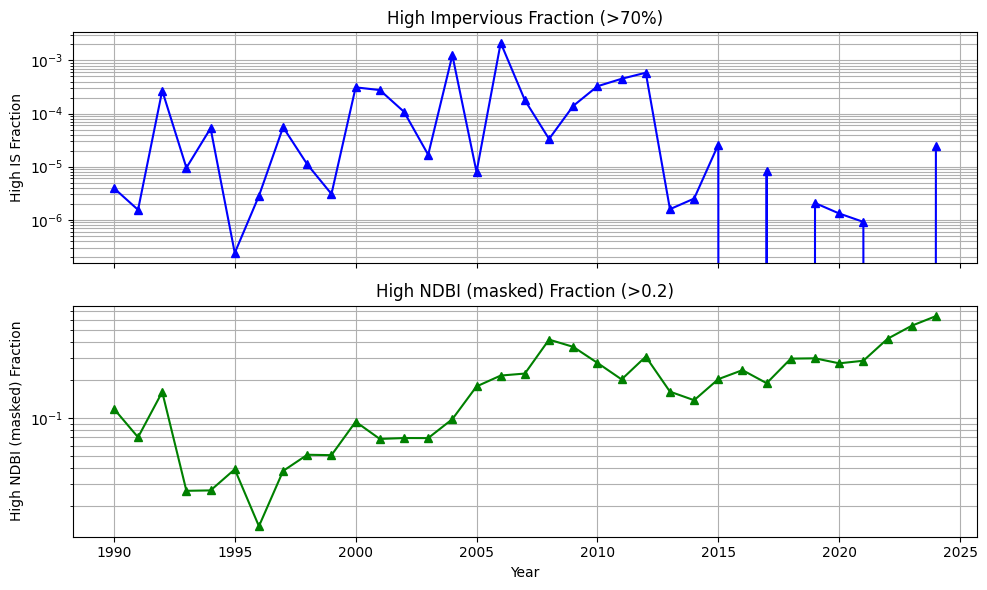

In [441]:
# High fraction of impervious surface and NDBI (plots unfinished, need to fix scaling)

fig2, axs2 = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# High IS fraction
axs2[0].plot(years, final_df['high_IS_frac'], marker='^', color='blue')
axs2[0].set_yscale('log')
axs2[0].set_ylabel('High IS Fraction')
axs2[0].set_title('High Impervious Fraction (>70%)')
axs2[0].grid(True, which='both')

# High NDBI (masked) fraction
axs2[1].plot(years, final_df['high_NDBI_masked_frac'], marker='^', color='green')
axs2[1].set_yscale('log')
axs2[1].set_ylabel('High NDBI (masked) Fraction')
axs2[1].set_xlabel('Year')
axs2[1].set_title('High NDBI (masked) Fraction (>0.2)')
axs2[1].grid(True, which='both')

plt.tight_layout()


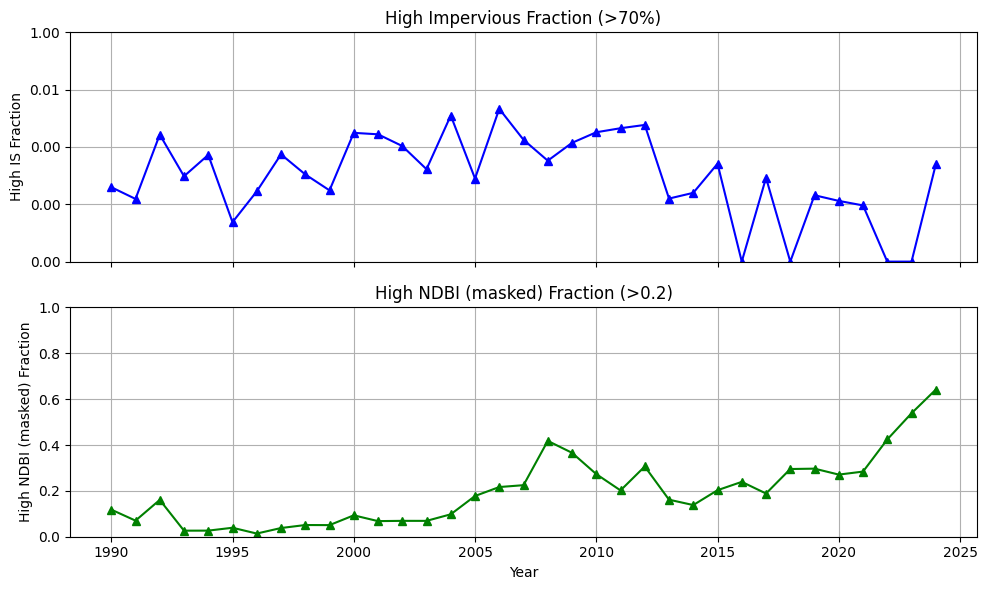

In [448]:
from matplotlib.ticker import ScalarFormatter

fig2, axs2 = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Fix zero values for log scale
high_IS_frac = final_df['high_IS_frac'].replace(0, 1e-8)
high_NDBI_masked_frac = final_df['high_NDBI_masked_frac']

# Formatter to disable scientific notation
plain_formatter = ScalarFormatter(useMathText=False)
plain_formatter.set_powerlimits((0, 0))

# High IS fraction
axs2[0].plot(years, high_IS_frac, marker='^', color='blue')
axs2[0].set_yscale('log')
axs2[0].set_ylim(1e-8, 1)
axs2[0].set_ylabel('High IS Fraction')
axs2[0].set_title('High Impervious Fraction (>70%)')
axs2[0].yaxis.set_major_formatter(plain_formatter)
axs2[0].grid(True, which='both')

# High NDBI masked fraction
axs2[1].plot(years, high_NDBI_masked_frac, marker='^', color='green')
axs2[1].set_yscale('linear')
axs2[1].set_ylim(0, 1)
axs2[1].set_ylabel('High NDBI (masked) Fraction')
axs2[1].set_xlabel('Year')
axs2[1].set_title('High NDBI (masked) Fraction (>0.2)')
axs2[1].yaxis.set_major_formatter(plain_formatter)
axs2[1].grid(True, which='both')

plt.tight_layout()
plt.show()


# Export and save data (optional)

In [353]:
# Download annual composites directly to local drive
start_year = 1990
end_year = 2025

for yr in range(start_year, end_year):
    filename = os.path.join(landsat_dir, f'shanghai_IS_{yr}.tif')

    geemap.download_ee_image(   # geemap+geedim auto-tiles & merges
        annual_image(yr, return_only_indices=True),
        filename=filename,
        region=shanghai)



📡 Collecting Landsat data for 1990
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1990.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1991
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1991.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1992
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1992.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1993
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1993.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1994
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1994.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1995
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1995.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1996
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1996.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1997
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1997.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1998
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1998.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 1999
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_1999.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2000
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2000.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2001
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2001.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2002
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2002.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2003
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2003.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2004
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2004.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2005
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2005.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2006
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2006.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2007
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2007.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2008
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2008.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2009
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2009.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2010
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2010.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2011
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2011.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2012
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2012.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2013
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2013.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2014
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2014.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2015
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2015.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2016
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2016.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2017
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2017.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2018
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2018.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2019
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2019.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2020
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2020.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2021
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2021.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2022
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2022.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2023
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2023.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)


📡 Collecting Landsat data for 2024
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


shanghai_IS_2024.tif: |          | 0.00/176M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
# # Download annual composites using Google Drive
# start_year = 1990
# end_year = 2025
# drive_folder = 'landsat_shanghai'   # make folder in Drive

# for yr in range(start_year, end_year):
#     img  = annual_image(yr)
#     desc = f'shanghai_{yr}' # both task name & file prefix

#     task = ee.batch.Export.image.toDrive(
#         image = img,
#         description = desc,
#         folder = drive_folder,
#         fileNamePrefix = desc,
#         region = shanghai,
#         scale = 30,   # 30 m Landsat native resolution
#         crs = 'EPSG:32651', # For Shanghai (≈ 31°N, 121°E) the usual choice is UTM zone 51 N, EPSG 32651
#         maxPixels = 1e10    # bump the limit
#     )
#     task.start()
#     print('queued', yr, task.id)    # progress message

# # Periodically check on task status
# while task.active():
#     print("Status:", task.status()['state'])
#     time.sleep(10)

# print("Final:", task.status())

# # Wait till they finish, then pull the GeoTIFFs from Drive.

## Visually inspect and sanity check - ALTERNATIVE APPROACH (with downloaded data) (optional)

Year: 1990
# indices: 3, size: 4511 x 4865, projection: EPSG:32651
Year: 1990
# indices: 2, size: 4511 x 4865, projection: EPSG:32651


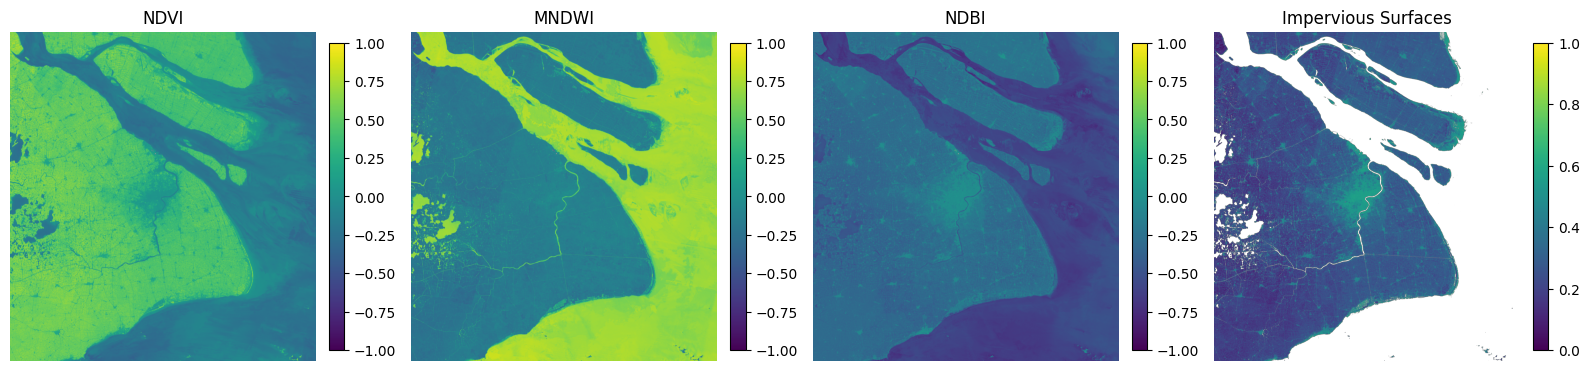

In [360]:
# Visualize indices
yr = 1990

filename = os.path.join(landsat_dir, f'shanghai_{yr}.tif')
with rasterio.open(filename) as src:
    print(f"Year: {yr}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 3 indices, matrix size, and projection
    ndvi, mndwi, ndbi = src.read(masked=True) # mask nodata automatically

filename_a = os.path.join(landsat_dir, f'shanghai_IS_{yr}.tif')
with rasterio.open(filename_a) as src:
    print(f"Year: {yr}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 1 indices, matrix size, and projection
    impervious = src.read(1, masked=True)  # Read only band 1


ranges = {
    'NDVI': (-1, 1),    # Range: -1 to 1 (usually vegetation > 0.2, water < 0).
    'MNDWI': (-1, 1),   # Range: -1 to 1 (water is positive, typically > 0).
    'NDBI': (-1, 1),    # Range: -1 to 1 (built-up > 0, vegetation negative).
    'Impervious Surfaces': (0, 1)   # Range: 0 to 1 (or 0 to 100 if in percentage form).
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, arr, name in zip(axes, [ndvi, mndwi, ndbi, impervious], ['NDVI', 'MNDWI', 'NDBI', 'Impervious Surfaces']):
    vmin, vmax = ranges[name]
    im = ax.imshow(arr, vmin=vmin, vmax=vmax)
    ax.set_title(name)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

In [361]:
# Sanity check of values

# Create table of statistics for each index
tbl = pd.DataFrame(
    dict(
        min=[ndvi.min(),  mndwi.min(),  impervious.min(), ndbi.min()],
        mean=[ndvi.mean(), mndwi.mean(), impervious.mean(), ndbi.mean()],
        max=[ndvi.max(),  mndwi.max(),  impervious.max(), ndbi.max()],
    ),
    index=['NDVI', 'MNDWI', 'Impervious Surfaces', 'NDBI']
)

print(tbl.round(3))

# NDVI values should be between -1 and 1; water dark ≈ <0, vegetation bright ≈ 0.4-0.8
# MNDWI > 0 ≈ water; < 0 ≈ land.
# NDBI > 0 ≈ built-up; < 0 ≈ veg/water.

                       min   mean    max
NDVI                -0.568  0.183  0.828
MNDWI               -0.776  0.190  0.952
Impervious Surfaces  0.000  0.274  0.799
NDBI                -0.920 -0.395  0.701


Year: 1990
# indices: 3, size: 4511 x 4865, projection: EPSG:32651
Year: 1990
# indices: 3, size: 4511 x 4865, projection: EPSG:32651
Year: 2017
# indices: 3, size: 4511 x 4865, projection: EPSG:32651
Year: 2017
# indices: 3, size: 4511 x 4865, projection: EPSG:32651


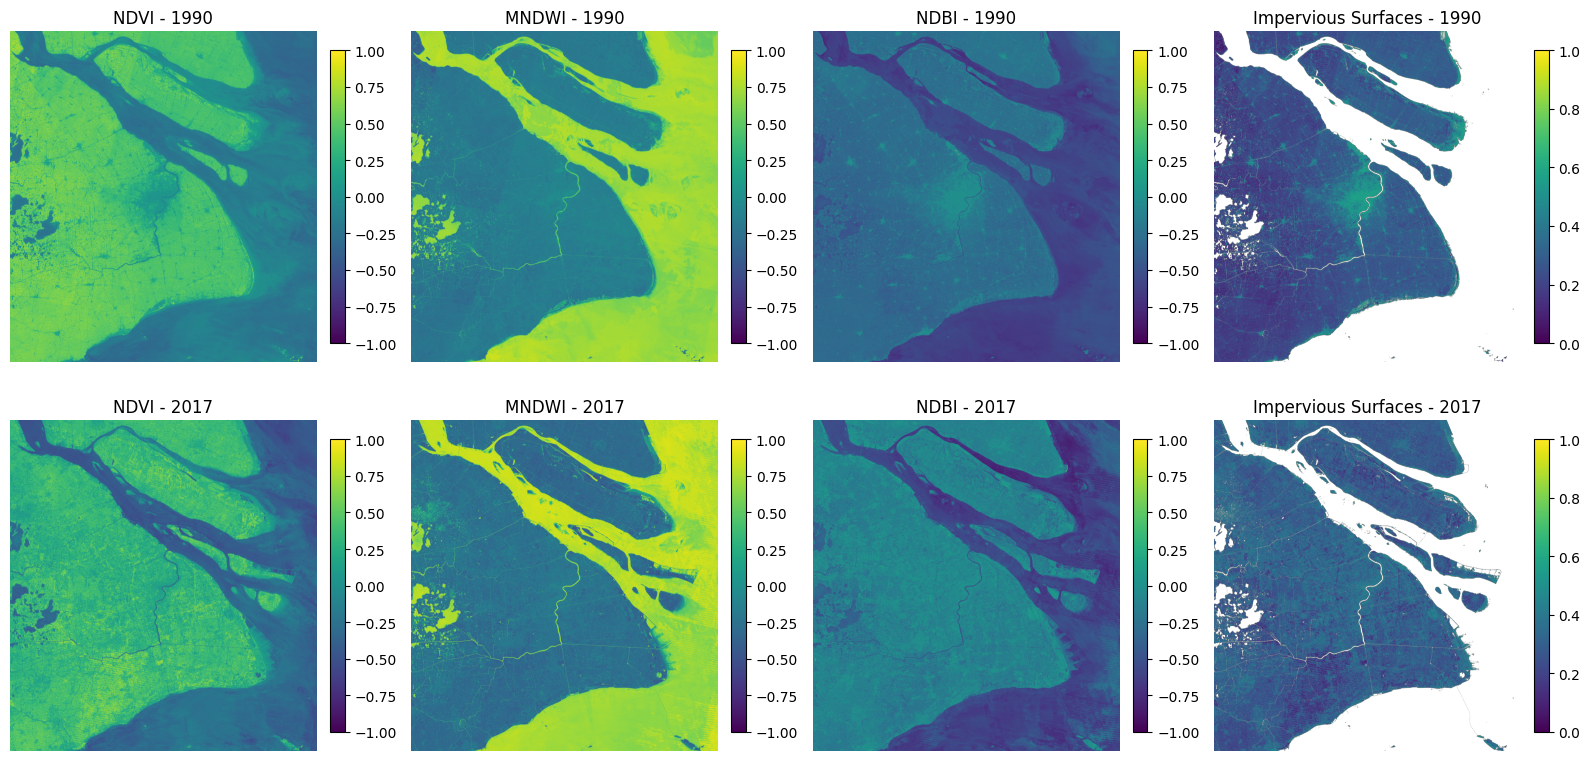

In [442]:
# Visually compare 2 different years

# Get 2 different years of data
yr_a = 1990
filename_a = os.path.join(landsat_dir, f'shanghai_{yr_a}.tif')
with rasterio.open(filename_a) as src:
    print(f"Year: {yr_a}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 3 indices, matrix size, and projection
    ndvi_a, mndwi_a, ndbi_a = src.read(masked=True) # mask nodata automatically

filename_a_is = os.path.join(landsat_dir, f'shanghai_IS_{yr_a}.tif')
with rasterio.open(filename_a_is) as src:
    print(f"Year: {yr_a}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 1 indices, matrix size, and projection
    impervious_a = src.read(1, masked=True)  # Read only band 1

yr_b = 2017
filename_b = os.path.join(landsat_dir, f'shanghai_{yr_b}.tif')
with rasterio.open(filename_b) as src:
    print(f"Year: {yr_b}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 3 indices, matrix size, and projection
    ndvi_b, mndwi_b, ndbi_b = src.read(masked=True) # mask nodata automatically

filename_b_is = os.path.join(landsat_dir, f'shanghai_IS_{yr_b}.tif')
with rasterio.open(filename_b_is) as src:
    print(f"Year: {yr_b}\n# indices: {src.count}, size: {src.width} x {src.height}, projection: {src.crs}")  # 1 indices, matrix size, and projection
    impervious_b = src.read(1, masked=True)  # Read only band 1


# Create figure
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

ranges = {
    'NDVI': (-1, 1),    # Range: -1 to 1 (usually vegetation > 0.2, water < 0).
    'MNDWI': (-1, 1),   # Range: -1 to 1 (water is positive, typically > 0).
    'NDBI': (-1, 1),    # Range: -1 to 1 (built-up > 0, vegetation negative).
    'Impervious Surfaces': (0, 1)   # Range: 0 to 1 (or 0 to 100 if in percentage form).
}

# Plot first year data (top row)
for i, (arr, name) in enumerate(zip([ndvi_a, mndwi_a, ndbi_a, impervious_a], ['NDVI', 'MNDWI', 'NDBI', 'Impervious Surfaces'])):
    vmin, vmax = ranges[name]
    im = axes[0, i].imshow(arr, vmin=vmin, vmax=vmax)
    axes[0, i].set_title(f'{name} - {yr_a}')
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], shrink=0.8, fraction=0.046, pad=0.04)

# Plot second year data (bottom row)
for i, (arr, name) in enumerate(zip([ndvi_b, mndwi_b, ndbi_b, impervious_b], ['NDVI', 'MNDWI', 'NDBI', 'Impervious Surfaces'])):
    vmin, vmax = ranges[name]
    im = axes[1, i].imshow(arr, vmin=vmin, vmax=vmax)
    axes[1, i].set_title(f'{name} - {yr_b}')
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], shrink=0.8, fraction=0.046, pad=0.04)

fig.tight_layout()
plt.show()

# Classify land use using Earth Engine algorithms (not part of our study)

In [443]:
# Load Landsat 8 SR data for 2020
image = annual_image(2020, return_only_indices=False)

# Bands to use for classification
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'NDVI', 'MNDWI', 'NDBI'] # excluded IS, since we were getting weird values

# 2. Load ESA WorldCover 2020
esa = ee.Image("ESA/WorldCover/v100/2020").clip(shanghai)

# 3. Reclassify ESA classes to GB/T 4-class scheme
from_classes = [50, 10, 20, 30, 40, 80, 60, 70, 90]
to_classes   = [0,   1,  1,  1,  1,  2,  3,  3,  3]  # 0=Urban, 1=Vegetation, 2=Water, 3=Others

lulc = esa.remap(from_classes, to_classes).rename('class')

# 4. Create stratified training samples
training_points = lulc.stratifiedSample(
    numPoints=0,    # total points
    classBand='class',
    classValues=[0, 1, 2, 3],
    classPoints=[1500, 1500, 1000, 1000],   # More balanced
    region=shanghai,
    scale=30,
    seed=42,
    geometries=True
)

# Add bands from Landsat image to training points
training = image.sampleRegions(
    collection=training_points,
    properties=['class'],
    scale=30
)


# Split data into training and validation sets (to prevent overfitting & get accuracy stats)
with_random = training.randomColumn('random')
split = 0.7
train_set = with_random.filter(ee.Filter.lt('random', split))
test_set = with_random.filter(ee.Filter.gte('random', split))

# Train Random Forest classifier on training set
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=200,
    variablesPerSplit=3,    # ~sqrt(number of features)
    minLeafPopulation=5,    # Prevent overfitting
    bagFraction=0.8,    # Bootstrap sampling
    seed=42
    ).train(features=train_set, classProperty='class', inputProperties=bands)

# Classify Image
classified = image.classify(classifier)



📡 Collecting Landsat data for 2020
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🌤️ Removing clouds and shadows...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🔧 Harmonizing different satellite sensors...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🧮 Calculating spectral indices...
🏙️  Mapping impervious surfaces...


In [444]:
# Validate using the test set
validated = test_set.classify(classifier)

# Compute accuracy metrics
conf_matrix = validated.errorMatrix('class', 'classification')
labels = ['Urban', 'Vegetation', 'Water', 'Others']
df = pd.DataFrame(conf_matrix.getInfo(), index=[f'True {l}' for l in labels], columns=[f'Pred {l}' for l in labels])
print(df)
print('Overall Accuracy:', conf_matrix.accuracy().getInfo())
print('Kappa:', conf_matrix.kappa().getInfo())

# Confusion Matrix:
#   Rows = Actual, Columns = Predicted
#   Diagonal = correct predictions
#   Off-diagonal = misclassifications

# Overall Accuracy (OA):
#   Proportion of correct predictions (0-1)
#   High = good overall performance

# Kappa:
#   Agreement beyond chance (-1 to 1)
#   <0.4 poor, 0.4-0.6 moderate, 0.6-0.8 good, >0.8 excellent


                 Pred Urban  Pred Vegetation  Pred Water  Pred Others
True Urban              338               65           1           40
True Vegetation          88              359           0           32
True Water                4                6           1           11
True Others             131               86           1           87
Overall Accuracy: 0.628
Kappa: 0.42696502933939046


In [445]:
# Define a smaller area to plot (center of Shanghai, ~10x10 km)
# Otherwise, the map is too large to display
subset = ee.Geometry.Rectangle([121.2, 31.1, 121.5, 31.3])

# Define visualization palette
palette = ['red', 'green', 'blue', 'yellow']  # Urban, Vegetation, Water, Others

# True color visualization using Landsat bands
true_color_vis = {
    'bands': ['red', 'green', 'blue'],
    'min': 0,
    'max': 0.3
}


# Initialize map with street basemap
Map = geemap.Map(basemap='TERRAIN')

# Center and zoom
Map.centerObject(subset, 11)

# Add true color image
Map.addLayer(image.clip(subset), true_color_vis, 'True Color (RGB)')

# Add classified map with transparency
Map.addLayer(classified.clip(subset),
             {'min': 0, 'max': 3, 'palette': palette, 'opacity': 0.5},
             'LULC Classification')
Map

Map(center=[31.200051768827027, 121.34999999999982], controls=(WidgetControl(options=['position', 'transparent…